In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import zipfile

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)
with zipfile.ZipFile('spam_ham_data.zip') as item:
    with item.open("train.csv") as f:
        original_training_data = pd.read_csv(f)
    with item.open("test.csv") as f:
        test = pd.read_csv(f)
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)

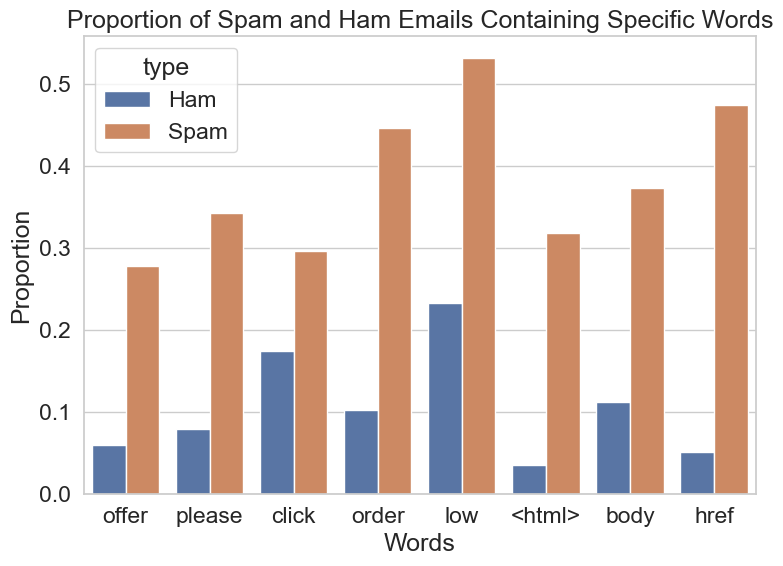

,variable,type,value
0,offer,Ham,0.059875
1,please,Ham,0.080071
2,click,Ham,0.174441
3,order,Ham,0.102770
4,low,Ham,0.232708
5,<html>,Ham,0.035210
6,body,Ham,0.112064
7,href,Ham,0.051832
8,offer,Spam,0.278415
9,please,Spam,0.342544


In [11]:
def words_in_texts(words, texts):
    """
    Args:
        words (list): Words to find.
        texts (Series): Strings to search in.
    
    Returns:
        A 2D NumPy array of 0s and 1s with shape (n, d) where 
        n is the number of texts, and d is the number of words.
    """
    if not words or texts.empty:
        # Return an empty array with the correct dimensions
        return np.empty((len(texts), len(words)), dtype=bool)
    
    indicator_lst = []
    for word in words:
        # Check if each word exists in each text
        pattern = fr"{word}"  # Match whole words
        indicator_lst.append(texts.str.contains(pattern, regex=True, na=False))
    
    # Combine all boolean series into a 2D array
    indicator_array = np.column_stack(indicator_lst)
    return indicator_array
train = train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts.
plt.figure(figsize=(8,6))
words = [ 'offer',"guaranteed", "please", "click", "order", "100%" , "money","cash",  "quote", "investment", "low", "loan", ]
words += ["save", "unlimited", "call"]

spam_keywords =[ 'offer',"please", "click", "order","low", "<html>", "body", "href"]
#spam_keywords += [ "limited", "dear", "saw your",  "loan", "money","cash","investment",]

patterns = [

    r"<a[^>]*href=\"http[^\"]*\"",
    r"\b(100%|guaranteed|limited|free|winner|offer|click here|act now|urgent)\b",
"limited",
]
# Step 2: Use words_in_texts to create an indicator matrix
indicator_matrix = words_in_texts(spam_keywords, train["email"])

# Step 3: Add labels and calculate proportions
train["label"] = train["spam"].map({1: "Spam", 0: "Ham"})  # Map labels to "Spam" and "Ham"
train_indicator = pd.DataFrame(indicator_matrix, columns=spam_keywords)
train_indicator["label"] = train["label"]

# Step 4: Calculate proportions for each word
proportions = train_indicator.groupby("label").mean().T
proportions = proportions.reset_index().melt(id_vars="index", 
                                             var_name="type", 
                                             value_name="value")
proportions.rename(columns={"index": "variable"}, inplace=True)
sns.barplot(data=proportions, x="variable", y="value", hue="type")
plt.title("Proportion of Spam and Ham Emails Containing Specific Words")
plt.ylabel("Proportion")
plt.xlabel("Words")

plt.tight_layout()
plt.show()
proportions

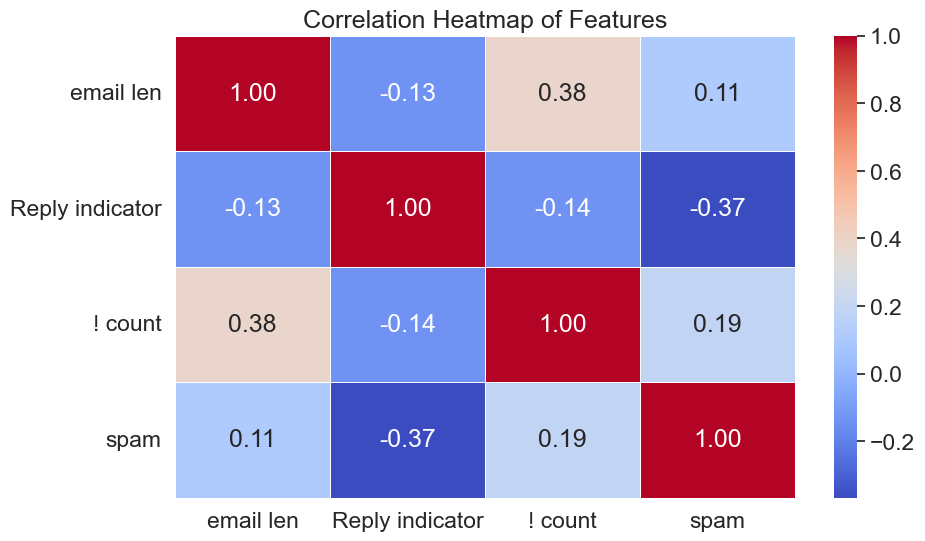

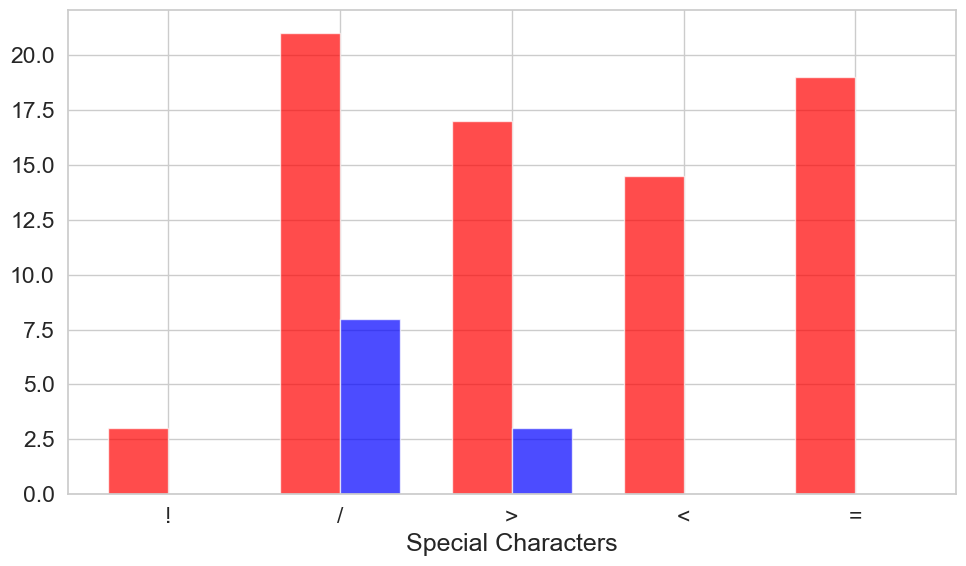

In [12]:

def remove_outlier_iqr(data, col):
    sr = data[col].describe()
    Q1 = sr['25%']
    Q3 = sr['75%']
    IQR = Q3 - Q1
    iqr_bot = Q1 - 1.5 * IQR
    iqr_top = Q3 + 1.5 * IQR
    data = data[(data[col] >= iqr_bot) & (data[col] <= iqr_top)]
    data = data.reset_index(drop=True) 
    return data
count_char = lambda data, char: data["email"].apply(lambda x: x.count(char))
re_ind = lambda data: data['subject'].apply(lambda x: 1 if isinstance(x, str) and 'Re' in x else 0)
def calculate_word_percentage(text, word_list):

    # Normalize both the text and word list to lowercase for comparison
    word_list_set = set(word.lower() for word in word_list)
    words = [word.lower() for word in text.split()]
    
    # Count words that match
    matching_count = sum(1 for word in words if word in word_list_set)
    
    # Avoid division by zero if the text contains no words
    total_words = len(words)
    if total_words == 0:
        return 0.0
    
    # Calculate the percentage
    percentage = (matching_count / total_words)
    return percentage
train["email len"] = train["email"].apply(len)
train_filt_1 = remove_outlier_iqr(train[train["spam"]==1],"email len")
train_filt_0 = remove_outlier_iqr(train[train["spam"]==0],"email len")
def count_sentences(email):
    # Define a regular expression to match sentence-ending punctuation
    sentence_endings = re.compile(r' [.!?]{1}')

    sentences = re.split(sentence_endings, email)
    sentences = [s for s in sentences if s.strip()] 
    return len(sentences)
""" fig, axes = plt.subplots(1, 2)
sns.histplot(data=train_filt_1[train_filt_1["spam"]==1],x="email len",stat="density", ax=axes[0], color="red")
sns.histplot(data=train_filt_0[train_filt_0["spam"]==0],x="email len",stat="density", ax=axes[1],color="green") """
train["! count"] = count_char(train,'!')
train_filt_1 = remove_outlier_iqr(train[train["spam"]==1],"! count")
train_filt_0 = remove_outlier_iqr(train[train["spam"]==0],"! count")
""" fig, axes = plt.subplots(1, 2)
sns.histplot(data=train_filt_1[train_filt_1["spam"]==1],x="! count",stat="density", ax=axes[0], color="red")
sns.histplot(data=train_filt_0[train_filt_0["spam"]==0],x="! count",stat="density", ax=axes[1],color="green")
plt.show() """
train["Reply indicator"] = re_ind(train)

corr_df = train[['email len',  'Reply indicator', "! count", 'spam']]
corr_matrix = corr_df.corr()

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap of Features")
plt.show()

spam_keywords = ['free',  'offer',"guaranteed", "please", "click", "order" ]
def count_keywords_in_email(keywords, text_series):
    counts = []
    for text in text_series:
        count = sum([text.count(keyword) for keyword in keywords])
        counts.append(count)
    
    return counts
#train['spam word count'] = count_keywords_in_email(spam_keywords, train['email'])

words_in_texts(spam_keywords,train["email"])
dummy_array = words_in_texts(spam_keywords, train['email'])

dummy_df = pd.DataFrame(dummy_array, columns=spam_keywords)

train = pd.concat([train, dummy_df], axis=1)

""" cols = train.columns[-6:].tolist()
corr_df = train[cols + [ "spam"]]
corr_matrix = corr_df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap of Words")
plt.show() """

""" train["num scentences"] = train["email"].apply(count_sentences)
avg_sentence_spam = train[train['spam'] == 0]['num scentences'].mean()
avg_sentence_ham = train[train['spam'] == 1]['num scentences'].mean()
print("Average Sentence of Spam Emails:", avg_sentence_spam)
print("Average Sentence of Ham Emails:", avg_sentence_ham)

# Plotting the graph
plt.bar(['Spam', 'Ham'], [avg_sentence_spam, avg_sentence_ham], color=['Blue', 'black'])
plt.title('Average Sentence of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Sentence')
plt.show() """
# Assuming data is a DataFrame with 'email' and 'spam' columns
# 'spam' column contains 1 for spam and 0 for ham
chars = ['!',   '=',  '>', '<','/' ]

chars = list(set(chars))  # Remove duplicates

# Function to count the individual characters
def count_individual_chars(data, chars):
    result = {}
    for char in chars:
        result[char] = data["email"].apply(lambda x: x.count(char))
    return pd.DataFrame(result)

# Count individual characters
char_counts = count_individual_chars(train, chars)

# Add the spam label to the counts
char_counts['spam'] = train['spam']

# Calculate mean character counts for spam and ham emails
spam_means = char_counts[char_counts['spam'] == 1].median(axis=0).drop('spam')
ham_means = char_counts[char_counts['spam'] == 0].median(axis=0).drop('spam')

# Plotting
x = np.arange(len(chars))  # X-axis positions
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, spam_means, width, label='Spam', color='red', alpha=0.7)
ax.bar(x + width/2, ham_means, width, label='Ham', color='blue', alpha=0.7)

# Labels, title, and legend
ax.set_xticks(x)
ax.set_xticklabels(chars)
ax.set_xlabel('Special Characters')


# Show the plot
plt.tight_layout()
plt.show()

In [13]:
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, classification_report, auc 
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import re
from collections import Counter

In [ ]:
count_char = lambda data, chars: data["email"].apply(
    lambda x: sum(x.count(c) for c in chars)
)
re_ind = lambda data: data['subject'].apply(lambda x: 1 if isinstance(x, str) and 'Re' in x else 0)
spam_keywords = [ 'offer',"guaranteed", "please", "click", "order", "100%" ]
#spam_keywords += ["save", "unlimited",   "limited", "saw your","money","cash",  "quote", "investment", "low", "loan" ]
chars = ['!', '?', '%', '&', '+',  '=','<', '>', '%', '*']
chars = ['!', '=',  '>', '<', '%','/' ]
spam_keywords = [ 'offer',"please", "click", "order", "low","<html>", "body", "href"]


regex = [                  r"<a[^>]*href=\"http[^\"]*\"",
    r"\b(100%|guaranteed|limited|free|winner|offer|click here|act now|urgent|please|order|money|cash|quote|investment|loan)\b"    ]
def count_sentences(email):
    # Define a regular expression to match sentence-ending punctuation
    sentence_endings = re.compile(r' [.!?]{1}')

    sentences = re.split(sentence_endings, email)
    sentences = [s for s in sentences if s.strip()] 
    return len(sentences)

def pipeline_og(data, spam = False):
    df = pd.DataFrame()
    df["email len"] = data["email"].apply(len)
    if spam:
        df["spam"] = data["spam"]
    # Feature: Count of '!' in the email
    df["special count"] = count_char(data, chars)
    #df["Reply indicator"] = re_ind(data)
    #df["secentence count"] = data["email"].apply(count_sentences)
    #words_in_texts(spam_keywords,data["email"])
    #df["spam word percent"] = data["email"].apply(lambda x: calculate_word_percentage(x, spam_keywords))
    dummy_array = words_in_texts(spam_keywords, data['email'])
    dummy_df = pd.DataFrame(dummy_array, columns=spam_keywords)
    df = pd.concat([df, dummy_df], axis=1)
    df = df.dropna()
    return df


def pipeline(data):
    # Initialize the DataFrame
    df = pd.DataFrame()
    # Feature: Length of the email
    df["email len"] = data["email"].apply(len) 
    # Feature: Count of '!' in the email
    
    df["special count"] = count_char(data, chars)
    # Feature: Reply indicator
    #df["Reply indicator"] = re_ind(data)    
    #df["secentence count"] = data["email"].apply(count_sentences)
    #df["spam word percent"] = data["email"].apply(lambda x: calculate_word_percentage(x, spam_keywords))
    # Feature: Dummy variables for spam keywords

    dummy_array = words_in_texts(spam_keywords, data['email'])
    dummy_df = pd.DataFrame(dummy_array, columns=spam_keywords)
    df = pd.concat([df, dummy_df], axis=1)
    #df = df.dropna()
    df = pipeline_og(data)
    """dummy_array = words_in_texts(regex, data['email'])
    dummy_df = pd.DataFrame(dummy_array, columns=regex)
    df = pd.concat([df, dummy_df], axis=1)
     """
    # Ensure the number of rows is consistent
    #assert df.shape[0] == data.shape[0], "Row count mismatch after feature engineering."
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    imputer = SimpleImputer(strategy='mean')
    # Fit and transform the data to replace NaN values
    X_imputed = imputer.fit_transform(X_scaled)
    # Apply PCA for dimensionality reduction
    pca = PCA()
    X_pca = pca.fit_transform(X_imputed)
    # Ensure the number of rows in PCA output matches the input
    #assert X_pca.shape[0] == data.shape[0], "Row count mismatch after PCA."
    pt = PowerTransformer()
    pt_X= pt.fit_transform(X_pca)
    return pt_X

X = pipeline(train)
Y = train["spam"]
param_grid = {
    'C': [ 0.001, 0.01, 0.1, 1,50,100,250,500,1000,1500,2000,2500],
    'penalty': ['l1', 'l2'],  # Add 'elasticnet'
    'solver': ['liblinear', 'saga', "newton-cholesky", "sag"],
    'multi_class': ['ovr', 'multinomial', 'auto'],   
    'max_iter': [1,5,10,25, 100],
    "warm_start":[True,False],
    "n_jobs" : [-1]
}


model = LogisticRegression(C=100, max_iter=5, multi_class="multinomial",penalty="l2", solver="sag",warm_start=False)
#gscv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy',error_score=np.nan, n_jobs=-1)
model.fit(X,Y)
""" 
kf = KFold(n_splits=5, shuffle=True,random_state=42)
fold_train_accuracies=[]
fold_valid_accuracies=[]
models=[]
params = []
gs = []
tri, tei = [],[]

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Processing Fold {fold + 1}...")
    # Split data into train and test for this fold
    tri.append(train_index)
    tei.append(test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy',error_score=np.nan, n_jobs=-1)
    # Fit the model
    grid_search.fit(X_train, y_train)
    model =  grid_search.best_estimator_
    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate the accuracy
    train_accuracy = grid_search.best_score_
    validation_accuracy = accuracy_score(y_test, y_pred)
    print(f"Fold {fold + 1} Training Accuracy: {train_accuracy:.4f}")
    print(f"Fold {fold + 1} Validation Accuracy: {validation_accuracy:.4f}")
    # Append to fold_accuracies
    fold_train_accuracies.append(train_accuracy)
    fold_valid_accuracies.append(validation_accuracy)
    models.append(model) 
    params.append(grid_search.best_params_)
    gs.append(grid_search) """

""" i = fold_valid_accuracies.index(max(fold_valid_accuracies))
model = models[i] 
X_train, X_test = X[tri[i]], X[tei[i]]
y_train, y_test = Y.iloc[tri[i]], Y.iloc[tei[i]] """
#grid_search= gs[i]
#model = gscv.best_estimator_
train_pred = model.predict(X)
""" valid_pred = model.predict(X_test) """

# Define your processing function, processed data, and model here. 
# You may find it helpful to look through the rest of the questions first!

""" if ("train_conf_matrix" and "valid_conf_matrix") in locals():
    print("Previous Training Confusion Matrix:")
    print(train_conf_matrix)
    print("\nPrevious Validation Confusion Matrix:")
    print(valid_conf_matrix)
    print(f"Previous Training accuracy: {train_accuracy}")
    print(f"Previous Validation accuracy: {valid_accuracy}") """
#model.fit(X_train, y_train)
#model current metrics
""" 
print("Best parameters:", gscv.best_params_)
print("Best score:", gscv.best_score_)
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    train_accuracy = fold_train_accuracies[fold]
    validation_accuracy = fold_valid_accuracies[fold]
    print(f"Fold {fold + 1} Training Accuracy: {train_accuracy:.4f}")
    print(f"Fold {fold + 1} Validation Accuracy: {validation_accuracy:.4f}")
train_accuracy = accuracy_score(Y, train_pred)
#valid_accuracy = accuracy_score(y_test, valid_pred)
print(f"Training accuracy: {train_accuracy}")
#print(f"Validation accuracy: {valid_accuracy}") """


train_conf_matrix = confusion_matrix(Y, train_pred).T
#valid_conf_matrix = confusion_matrix(y_test, valid_pred).T

print("Training Confusion Matrix:")
print(train_conf_matrix)
""" print("\nValidation Confusion Matrix:")
print(valid_conf_matrix) """

# Convert to DataFrame for better handling
""" test_data = train.iloc[tei[i]].reset_index(drop=True)
mr ={
    "actual": y_test.reset_index(drop=True),
    "predicted": valid_pred
}
mr = pd.DataFrame(mr)
test_data = pd.concat([test_data,mr], axis=1) """

Training Confusion Matrix:
[[5401  906]
 [ 194 1012]]


c:\Users\murar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\murar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


' test_data = train.iloc[tei[i]].reset_index(drop=True)\nmr ={\n    "actual": y_test.reset_index(drop=True),\n    "predicted": valid_pred\n}\nmr = pd.DataFrame(mr)\ntest_data = pd.concat([test_data,mr], axis=1) '